# Import libraries

In [21]:
import jax
import numpy as np
import ximinf.nn_inference as nninf
import ximinf.nn_test as nnte
import ximinf.nn_train as nntr
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Set device type

In [22]:
jax.devices()
cpu = jax.devices("cpu")[0]
gpu = jax.devices("gpu")[0]

key = jax.random.PRNGKey(42)

# Load data

In [23]:
# columns = ['magobs', 'magobs_err','x1', 'x1_err', 'c', 'c_err', 'mass', 'mass_err', 'localcolor', 'localcolor_err', 'prompt', 'z']
columns = ['magobs', 'magobs_err', 'c', 'c_err', 'x1','x1_err', 'mass', 'mass_err', 'localcolor', 'localcolor_err']
df = pd.read_parquet("../data/inference_data_frame.parquet")
data = df[columns].copy()

In [24]:
z = df.loc[data.index, 'z']
magobs = data["magobs"]      # (N,M)
mask = magobs != 0           # (N,M)

In [25]:
# Take care to not run the correction twice
mu_planck18, magobs_corr = nntr.rm_cosmo(z,
                                        magobs,
                                        z_max=0.2,
                                        n_grid=10_000)

data.loc[data.index, 'magobs'] = magobs_corr

Building Planck18 interpolation...
... done
Interpolating mu for dataset...
... done


# Load NN

In [26]:
# Parameters
models_per_group, models_config = nninf.load_autoregressive_nn('../data/NNs/nn_model_sigma_V4')

In [27]:
# Make a copy to avoid SettingWithCopyWarning
data_norm = data.copy()

data_stats = models_config['shared']['data_stats']

for col in data_norm.columns:
    mu = data_stats[col]['mu']
    sigma = data_stats[col]['sigma']
    
    if col == 'magobs':
        # mask zeros, standardize only non-zero values
        data_norm.loc[mask, col] = (data_norm.loc[mask, col] - mu) / sigma
    else:
        data_norm[col] = (data_norm[col] - mu) / sigma

# MCMC

## Set priors

In [28]:
for model_g in models_per_group:
    model_g.eval()  # disable dropout, etc.

global_param_names = models_config['shared']['global_param_names']
print(f"Parameters : {global_param_names}")

param_groups = models_config['shared']['param_groups']



Parameters : ['mabs', 'beta', 'alpha_low', 'alpha_high', 'gamma', 'sigma_int']


In [29]:
# ========== Set priors ========== (In alphabetical order ?)
BOUNDS = jnp.array([
    [models_config['shared']['bounds'][p]['min'], models_config['shared']['bounds'][p]['max']]
    for p in global_param_names
])

BOUNDS_norm = jnp.array([
    [models_config['shared']['bounds_norm'][p]['min'], models_config['shared']['bounds_norm'][p]['max']]
    for p in global_param_names
])

In [30]:
# Initial position at the middle of the priors from bounds
# theta_init = (BOUNDS[:, 0] + BOUNDS[:, 1]) / 2.0
param_stats = models_config['shared']['param_stats']
theta_init = jnp.asarray([-19.35+19.3, 3.2, -0.3, -0.1, 0.15, 0.15])
theta_init_dict = {name: theta_init[i] for i, name in enumerate(global_param_names)}
theta_init_normed_dict = nntr.normalize(theta_init_dict, param_stats)
theta_init_normed = jnp.array([theta_init_normed_dict[name] for name in global_param_names])

## Prepare input

In [31]:
# Convert each column to a 1D array and concatenate into shape (M*C,)
# Prepare inference arrays
data_arrays = [jnp.asarray(data_norm[col].to_numpy()) for col in columns]  # list of (M,)
n_cols = len(columns)
M = len(data_arrays[0])

# Stack along last axis to get shape (M, n_cols)
data_stacked = jnp.stack(data_arrays, axis=-1)  

# Flatten and add batch dimension: (1, M * n_cols)
data_concat_infer = data_stacked.reshape(1, M * n_cols)

# mask_infer = jnp.ones_like(data_arrays[0])

# Concatenate features + mask
inputs_infer = jnp.concatenate([data_concat_infer, jnp.asarray(mask).reshape(1,M)], axis=-1)

print(inputs_infer.shape)

(1, 11000)


## Launch MCMC

In [32]:
# ========== MCMC Sampling ==========

def log_post(theta):
    # Use the new grouped log-prob function
    return nnte.log_prob_fn_groups(
        theta,
        models_per_group,  # list of models per group
        inputs_infer,
        BOUNDS_norm,
        param_groups,
        global_param_names
    )

print("Launch MCMC ...")
# Run MCMC
key, post = nnte.sample_posterior(
    log_post,
    n_warmup=2000,
    n_samples=1000,
    init_position=theta_init_normed,
    rng_key=key
)

print("...finished")

Launch MCMC ...
...finished


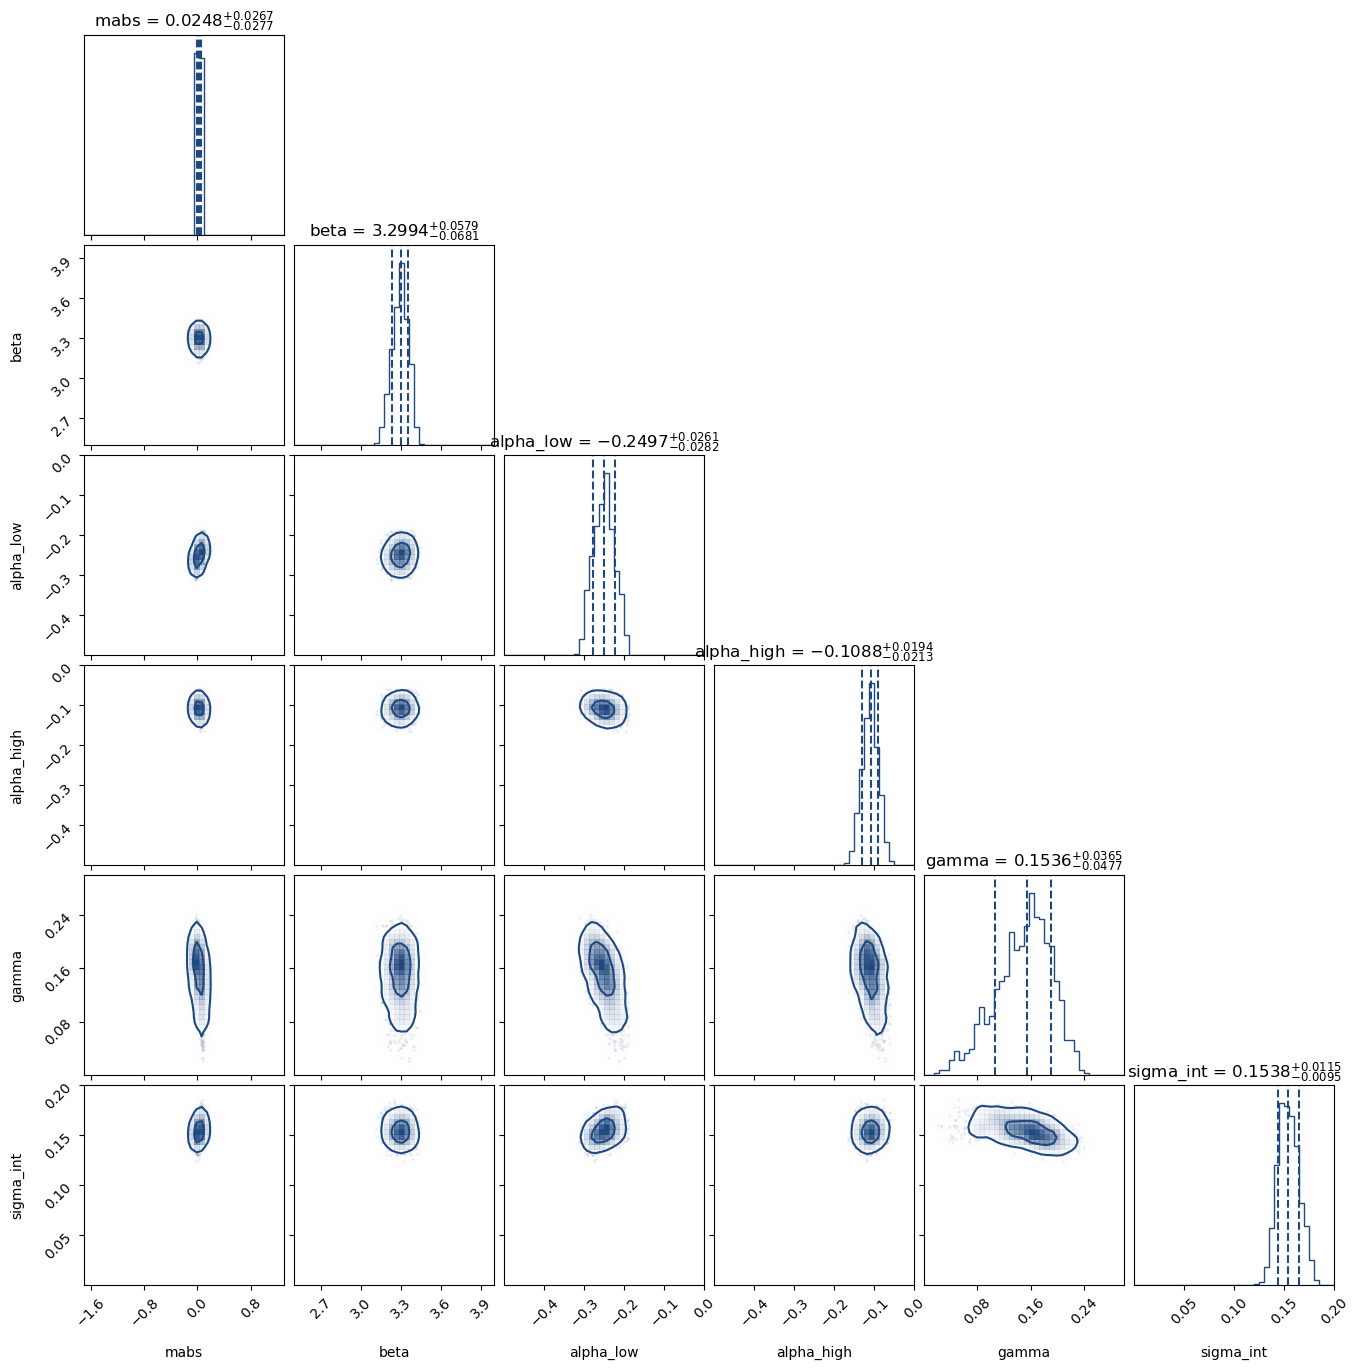

In [33]:
import corner
import numpy as np

# post has shape (n_samples, n_params)
n_samples, n_params = post.shape

# Convert post from array to dict with column names
post_dict = {name: post[:, i] for i, name in enumerate(global_param_names)}

# Unnormalize each parameter
post_unnormed_dict = nntr.unnormalize(post_dict, param_stats)

# Convert back to array for plotting
post_unnormed = jnp.stack([post_unnormed_dict[name] for name in global_param_names], axis=1)

# Now post_unnormed[:, i] contains the real-scale parameters
x = post_unnormed[:, 0]

fig = corner.corner(
    np.array(post_unnormed),
    labels=global_param_names,
    range=[tuple(b) for b in BOUNDS],
    quantiles=[0.16, 0.5, 0.84],      # 1D marginal: 1σ
    levels=[0.393469, 0.864665],     # 2D contours: 1σ, 2σ
    show_titles=True,
    title_fmt=".4f",
    bins=40,
    smooth=1.0,
    color="#1F487E",
    truth_color="#A31621", 
    truth_alpha=0.8
)

plt.savefig("./corner.png",dpi=150)
plt.show()

In [36]:
idx = [
    global_param_names.index("alpha_low"),
    global_param_names.index("alpha_high"),
    global_param_names.index("beta"),
    global_param_names.index("mabs"),
    global_param_names.index("gamma"),
    global_param_names.index("sigma_int"),
]

post_reordered = post_unnormed[:, idx]
post_reordered = post_reordered[:,:-1]

In [37]:

np.save("../data/results/sbi_posterior.npy", np.array(post_reordered))